In [4]:
import io

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from denseclus import DenseClus
from denseclus.categorical import extract_categorical
from denseclus.numerical import extract_numerical

SEED = 42  # random seed to set reproducibility as best we can

sns.set_style("darkgrid")
sns.set_context("notebook")

%matplotlib inline

/Users/bharven/Documents/amazon-denseclus/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data
Let's start by downloading publicly available *Census Income dataset* available at https://archive.ics.uci.edu/ml/datasets/Adult. In this dataset we have different attributes such as age, work class, education, country, race etc for each person. We also have an indicator of person's income being more than $50K a year. The prediction task is to determine whether a person makes over 50K a year.


### Data Description
Let's talk about the data. At a high level, we can see:

- There are 15 columns and around 32K rows in the training data
- 8 of the 14 features are categorical and remaining 6 are numeric

Now lets read this into a Pandas data frame and take a look.

In [6]:
region = boto3.session.Session().region_name

# read the census dataset
df = pd.read_csv(
    f"s3://sagemaker-example-files-prod-{region}/datasets/tabular/uci_adult/adult.data", header=None
)

## set column names
df.columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "IncomeGroup",
]

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,IncomeGroup
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


As you can see the data consists of both categorical and numeric features.
Generally, speaking this is problematic for traditional dimension reduction and clustering methods such as [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) as they rely input features to be numeric and assume that the values are shaped spherical in nature.

## Build clusters with numeric and categorical features separately

What happens if we treat the numerical and categorical features as separate datasts and cluster them individually? Lets explore.

We can use UMAP - a popular dimensionality reduction algorithm, coupled with HDBScan, a density-based clustering algorithm.

In [7]:
import hdbscan
import umap.umap_ as umap

In [8]:
default_umap_params = {
    "categorical": {
        "metric": "hamming",
        "n_neighbors": 30,
        "n_components": 5,
        "min_dist": 0.0,
    },
    "numerical": {
        "metric": "l2",
        "n_neighbors": 30,
        "n_components": 5,
        "min_dist": 0.0,
    },
}

hdbscan_params = {
    "min_cluster_size": 100,
    "min_samples": 15,
    "gen_min_span_tree": True,
    "metric": "euclidean",
}

### Numerical features

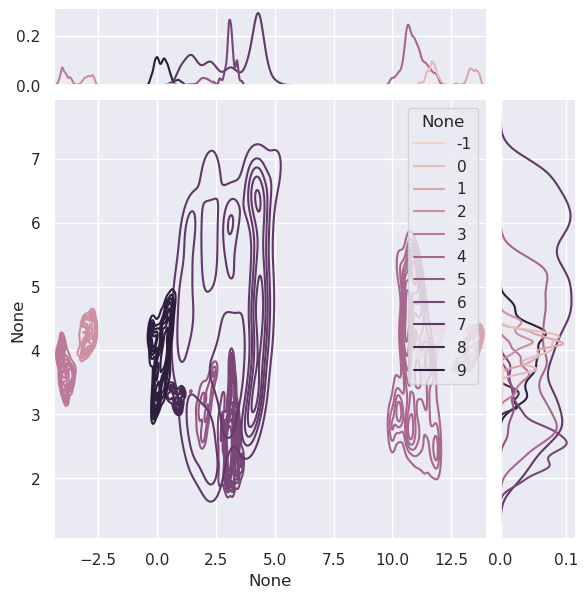

In [12]:
numerical_df = extract_numerical(df)

numerical_umap = umap.UMAP(
    random_state=SEED,
    n_jobs=1,
    verbose=False,
    low_memory=True,
    **default_umap_params["numerical"],
).fit(numerical_df)

numerical_hdb = hdbscan.HDBSCAN(**hdbscan_params).fit(numerical_umap.embedding_)

joint_plot = sns.jointplot(
    x=numerical_umap.embedding_[:, 0],
    y=numerical_umap.embedding_[:, -1],
    hue=numerical_hdb.labels_,
    kind="kde",
    marginal_ticks=True,
)

In [13]:
numerical_df = df.select_dtypes(include=[int, float])
numerical_df["segment"] = numerical_hdb.labels_

numerical_df.groupby(["segment"]).agg(["mean", "median"])

age                fnlwgt           education-num         \
              mean median           mean    median          mean median   
segment                                                                   
-1       32.835294   31.0  208386.282353  193459.0      5.341176    6.0   
 0       43.475871   42.0  191109.560992  177930.0      9.019437    9.0   
 1       44.677049   43.0  184376.141803  173794.5     13.568852   13.0   
 2       43.052147   42.0  189280.625767  175994.0     13.592025   13.0   
 3       40.679354   40.0  182644.532872  173998.0      8.996540    9.0   
 4       39.534990   38.0  186963.937198  177351.0     13.268599   13.0   
 5       17.881356   17.0  179488.457627  170585.5      6.789831    7.0   
 6       34.990684   26.0  193480.550273  181313.0      9.543848   10.0   
 7       37.617070   36.0  188690.237260  177420.0      9.472440    9.0   
 8       60.512346   63.0  182959.867284  179378.5      4.703704    4.0   
 9       40.270980   38.0  206395.005882  193102.5      5.144314    5.0   

         capital-gain         capital-loss         hours-per-week         
                 mean  median         mean  median           mean median  
segment                                                                   
-1           0.000000     0.0     0.000000     0.0      30.376471   30.0  
 0        8439.495308  4416.0     0.000000     0.0      41.333110   40.0  
 1       18440.653279  7688.0     0.000000     0.0      46.172951   45.0  
 2           0.000000     0.0  1917.032209  1902.0      45.639571   43.0  
 3           0.000000     0.0  1837.133795  1887.0      41.457901   40.0  
 4           0.000000     0.0     0.000000     0.0      42.351139   40.0  
 5           0.000000     0.0     0.000000     0.0      18.459322   20.0  
 6           0.000000     0.0     0.000000     0.0      21.755863   22.0  
 7           0.000000     0.0     0.000000     0.0      43.774943   40.0  
 8           0.000000     0.0     0.000000     0.0      19.049383   20.0  
 9           0.000000     0.0     0.000000     0.0      42.122353   40.0

From the above plot and descriptive stats generated from the clusters using only numerical features, we can see that:

- Cluster 1 seems to represent a younger demographic with lower education, income (fnlwgt), and working hours. This could be students or entry-level workers.
- Clusters 0, 1, 2, 4, 7, and 9 seem to represent middle-aged working professionals with higher education, income, and working hours.
- Cluster 5 clearly captures a very young demographic, likely teenagers/students based on the low age and hours worked. 
- Cluster 6 seems to be early career adults with moderate education and income.
- Cluster 8 represents older, retired people with lower education, income, and hours worked. 

Some limitations of using just these numerical features:

- We lack contextual categorical features like occupation, marital status, etc that would help distinguish the clusters more clearly.
- The clusters are formed solely based on central tendencies of numerical features. But subgroups within a cluster can exhibit very different characteristics. 
- Important outliers in the data may not be well-represented in the clusters.
- Numerical features alone may not fully capture more complex behavioral segments.

So while these numeric features give some interesting initial profiles, more categorical and behavioral features would likely result in more nuanced and meaningful customer segments.

### Categorical features

In [15]:
categorical_df = extract_categorical(df)

categorical_umap = umap.UMAP(
    random_state=SEED,
    n_jobs=1,
    verbose=False,
    low_memory=True,
    **default_umap_params["categorical"],
).fit(categorical_df)

categorical_hdb = hdbscan.HDBSCAN(**hdbscan_params).fit(categorical_umap.embedding_)
n_clusters = len(np.unique(categorical_hdb.labels_))
print(f"Number of clusters: {n_clusters}")

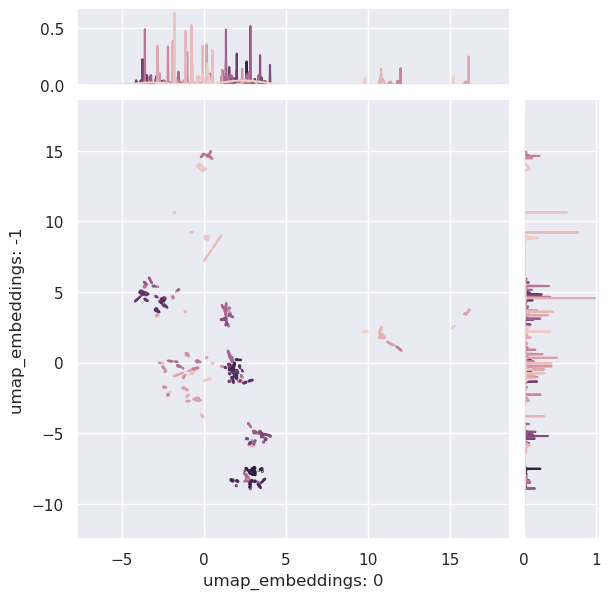

In [18]:
joint_plot = sns.jointplot(
    x=categorical_umap.embedding_[:, 0],
    y=categorical_umap.embedding_[:, -1],
    hue=categorical_hdb.labels_,
    kind="kde",
    marginal_ticks=True,
)
joint_plot.ax_joint.legend_.remove()
joint_plot.set_axis_labels("umap_embeddings: 0", "umap_embeddings: -1")

In [19]:
categorical_df = df.select_dtypes(include=[object])
categorical_df["segment"] = categorical_hdb.labels_

categorical_df.groupby("segment").describe(include="object")

workclass                                 education         \
            count unique                top  freq     count unique   
segment                                                              
-1           5658      9            Private  4117      5658     16   
 0            129      1                  ?   129       129     12   
 1            142      2                  ?   141       142     14   
 2            346      5            Private   235       346      6   
 3            843      1            Private   843       843      2   
...           ...    ...                ...   ...       ...    ...   
 108          124      4            Private   119       124      9   
 109          155      2            Private   154       155      3   
 110          111      6            Private    61       111      8   
 111          160      4   Self-emp-not-inc   151       160     12   
 112          372      6            Private   284       372     13   

                             marital-status         ...      sex        \
                   top  freq          count unique  ...      top  freq   
segment                                             ...                  
-1             HS-grad  1556           5658      7  ...     Male  3733   
 0             HS-grad    32            129      1  ...     Male   129   
 1             HS-grad    43            142      2  ...   Female   142   
 2             Masters   258            346      3  ...     Male   346   
 3             HS-grad   842            843      2  ...     Male   843   
...                ...   ...            ...    ...  ...      ...   ...   
 108      Some-college    57            124      2  ...     Male   124   
 109           HS-grad   153            155      3  ...     Male   155   
 110         Bachelors    48            111      1  ...     Male   111   
 111           HS-grad    75            160      5  ...     Male   160   
 112           HS-grad   138            372      3  ...     Male   372   

        native-country                              IncomeGroup         \
                 count unique             top  freq       count unique   
segment                                                                  
-1                5658     41   United-States  4839        5658      2   
 0                 129      7   United-States   120         129      1   
 1                 142     15   United-States   119         142      2   
 2                 346     13   United-States   323         346      1   
 3                 843     14   United-States   815         843      1   
...                ...    ...             ...   ...         ...    ...   
 108               124      4   United-States   121         124      1   
 109               155      3   United-States   152         155      1   
 110               111      7   United-States   103         111      1   
 111               160      9   United-States   147         160      2   
 112               372      9   United-States   360         372      1   

                       
            top  freq  
segment                
-1        <=50K  5058  
 0         >50K   129  
 1        <=50K   100  
 2         >50K   346  
 3        <=50K   843  
...         ...   ...  
 108      <=50K   124  
 109      <=50K   155  
 110      <=50K   111  
 111      <=50K   152  
 112      <=50K   372  

[114 rows x 36 columns]

From the above plot generated from the clusters using only categorical features, we can see that:

- 114 clusters formed from categorical features lead to many clusters that are very similar to each other.
- High sparsity. Categorical features often lead to high-dimensional sparse feature spaces, which makes clustering statistically less meaningful. With 114 clusters in a large sparse space, most of the clusters have very few data points.
- Difficult to interpret clusters - Clusters formed on categorical features alone are difficult to characterize and interpret. 

In summary, clustering on sole categorical features often lacks clear semantic meaning and differentiation between clusters. It tends to work better when combined with numeric features that provide more inherent structure. 

# DenseClus on all features (numerical + categorical)

With DenseClus this is not an issue because we use create UMAP embeddings for both categorical and numerical, combining the embedding space to output them into the densest space possible. Next HDBSCAN is run to group densities into clusters, resulting in groups of mixed-type data. 

All of this is done under the hood and just requires a `fit` call like below.

### There are 5 methods by which you can combine embeddings spaces (param: umap_combine_method, default=intersection)

- 'intersection'
- 'union'
- 'contrast'
- 'intersection_union_mapper'
- 'ensemble'

----------

Let's implement each one of the above methods and visualize their respective umap embeddings. 

Running method using: intersection
Max of 42 is greater than threshold 25
Hashing categorical features
Coverage 0.9941955099659101
Number of clusters: 10
------------------------------
Running method using: union
Max of 42 is greater than threshold 25
Hashing categorical features
Coverage 0.8202143668806241
Number of clusters: 115
------------------------------
Running method using: contrast
Max of 42 is greater than threshold 25
Hashing categorical features
Coverage 0.9574337397500077
Number of clusters: 20
------------------------------
Running method using: intersection_union_mapper
Max of 42 is greater than threshold 25
Hashing categorical features
Coverage 0.9947176069531034
Number of clusters: 6
------------------------------
Running method using: ensemble
Max of 42 is greater than threshold 25
Hashing categorical features
Coverage 0.9995086146002887
Number of clusters: 114
------------------------------


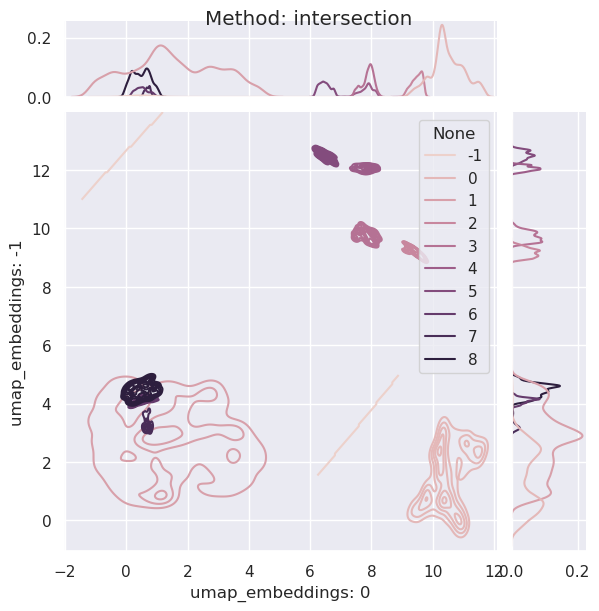

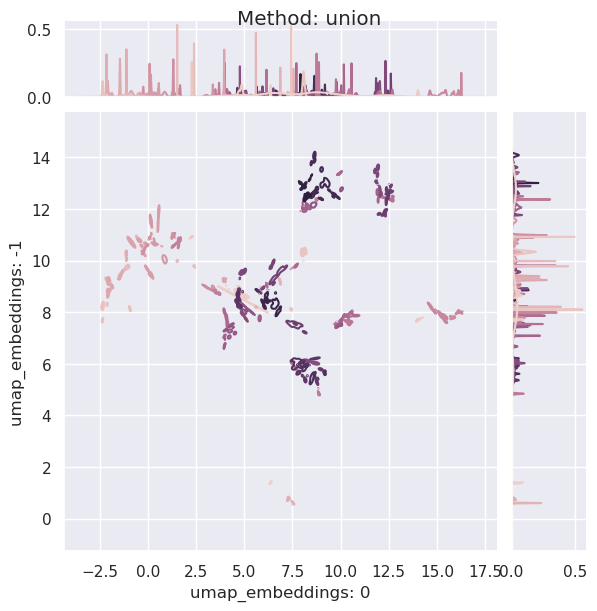

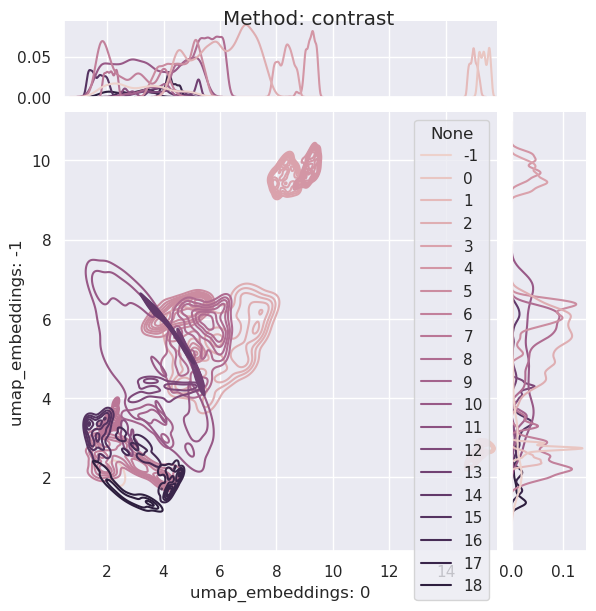

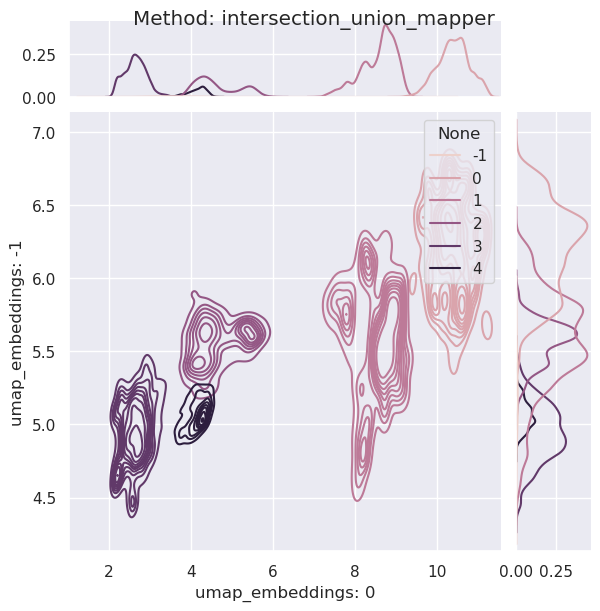

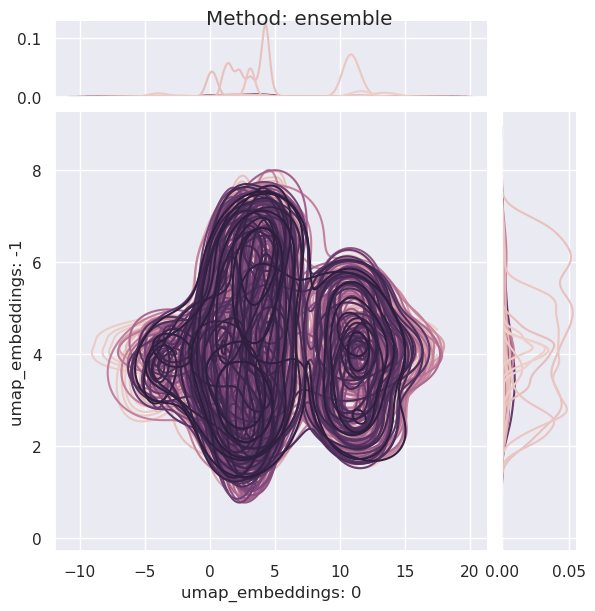

In [22]:
methods = ["intersection", "union", "contrast", "intersection_union_mapper", "ensemble"]

for method in methods:
    print(f"Running method using: {method}")
    clf = DenseClus(random_state=SEED, umap_combine_method=method)
    clf.fit(df)
    clusters = clf.evaluate()
    n_clusters = len(np.unique(clusters))
    print(f"Number of clusters: {n_clusters}")

    if hasattr(clf, "mapper_"):
        embeddings = clf.mapper_.embedding_
    else:
        embeddings = clf.numerical_umap_.embedding_

    joint_plot = sns.jointplot(
        x=embeddings[:, 0], y=embeddings[:, -1], hue=clusters, kind="kde", marginal_ticks=True
    )
    joint_plot.set_axis_labels("umap_embeddings: 0", "umap_embeddings: -1")

    joint_plot.fig.suptitle(f"Method: {method}")
    if n_clusters > 50:
        joint_plot.ax_joint.legend_.remove()

    print("-" * 30)

----------
As a recap the steps that happened are:

1) Numerical features were taken out and then reduced into a *dense* UMAP embedding

2) Categorical features got extracted and learned into a *dense* separate UMAP embedding

3) The two embeddings were then combined with one of the available operations ("intersection", "union", "contrast", "intersection_union_mapper", "ensemble")

4) HDBSCAN uses density-based spatial clustering to hierarchical-fashion to extract clusters from the combined space

All of these features are now attached as usable `DenseClus` object. 

----------
## Analysis:

Based on the above results for each method: `intersection_union_mapper` seems to be the suitable method for clustering our dataset. As you can see we have 5 distinct islands formed within the slice of the data. Clusters have formed around these densities which is exactly the behavior we expect DenseClus to do.

`Intersection_union_mapper` is a hybrid method that combines the strengths of both 'intersection' and 'union'. It first applies the 'intersection' method to preserve the numerical embeddings, then applies the 'union' method to preserve the categorical embeddings. This method is useful when both numerical and categorical data are important, but one type of data is not necessarily more important than the other.

Let's dive deep into Embedding Results for the intersection_union_mapper method:

In [7]:
clf = DenseClus(random_state=SEED, umap_combine_method="intersection_union_mapper")
clf.fit(df)

labels = clf.evaluate()

## Checking Embedding Results

Verify the embeddings are now densely shaped.

In [ ]:
for i in range(len(clf.mapper_.embedding_[0])):
    sns.kdeplot(clf.mapper_.embedding_[:, i], fill=True)

### Inspection of Cluster Results

Under the hood, among other steps, Denseclus uses HDBSCAN to cluster the data.

Let's look at the how the data got split.

In [ ]:
cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"]))

Upon examination there are exactly 5 clusters with -1 representing the noise found in the data.

### Profiling the Clusters

Finally, once clusters are formed, it's common practice to then describe what each one means.

Here, descriptive statistics is actually a very powerful (and efficient) tool to use.

In [ ]:
df["segment"] = labels

numerics = df.select_dtypes(include=[int, float]).drop(labels=["segment"], axis=1).columns.tolist()

df[numerics + ["segment"]].groupby(["segment"]).mean()

Let's ignore group `-1`.

Let's generate a profile for each of the segment, we can see that:
- Segment 0 has the oldest, most educated, and highest earning individuals working full-time. 
- Segment 1 has slightly younger, moderately educated, middle earning individuals working part-time.  
- Segment 2 has middle aged, less educated, moderate earning individuals working part-time.
- Segment 3 has the youngest, moderately educated, middle earning individuals working full-time.
- Segment 4 has older, less educated, lower earning individuals working full-time.


This is just profiling but descriptive statistics are revealing of what patterns are captured.

A similar type of analysis is possible with categorical features, with a reference shown below.

In [ ]:
categorical = df.select_dtypes(include=["object"])

In [ ]:
for c in categorical.columns:
    df.groupby(["segment"] + [c]).size().plot(
        kind="bar", color=sns.color_palette("deep", np.unique(labels).shape[0])
    )
    plt.title(c)
    plt.show()

## Conclusion

This notebook walked through how and why to use DenseClus to build high quality clusters from mixed-type data. We explored 5 methods to combine information from mixed type data: "intersection", "union", "contrast", "intersection_union_mapper", "ensemble", and compared their performance. 

When applying DenseClus to your datasets, you may wish to experiment with different combine methods and hyperparameter combinations to see what works the best on your data.